In [30]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [31]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)


def error_level_analysis(image, quality=95):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None


def preprocess_image(image, image_size=(224, 224)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)

In [32]:
def prepare_dataset(dataset_path, image_size=(224, 224), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [33]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Conv2D, Multiply, Add, Reshape, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2


from tensorflow.keras.layers import Lambda, Concatenate

# def spatial_attention_module(inputs):
#     """Spatial attention using average and max pooling."""
#     avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
#     max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs)
#     concat = Concatenate(axis=-1)([avg_pool, max_pool])

#     attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
#     return Multiply()([inputs, attention])


from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply,
    Conv2D, Concatenate, Activation, Lambda, Add
)
import tensorflow as tf


def cbam_module(inputs, reduction_ratio=8):
    channel = inputs.shape[-1]

    # ----- Channel Attention -----
    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = GlobalMaxPooling2D()(inputs)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_refined = Multiply()([inputs, channel_attention])

    # ----- Spatial Attention -----
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    spatial_attention = Conv2D(1, kernel_size=5, strides=1, padding='same', activation='sigmoid')(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature




def build_model_with_attention(image_size=(224, 224)):
    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

    base_model.trainable = False

    x = base_model.output
    x = cbam_module(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=2e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", "AUC"],
    )

    return model


In [34]:
def train_model(model, X, y, epochs=80):
    """Train the model with optimized parameters and class weighting."""
    X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)
    # early_stopping = EarlyStopping(
    #     monitor="val_loss", patience=10, restore_best_weights=True
    # )
    # lr_scheduler = ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.2, patience=10, min_lr=1e-7
    # )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
    )
    return model, history, X_test, y_test

In [35]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate various plots."""
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nTest Metrics:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

In [36]:
# Step 1: Build model
image_size = (224, 224)
model = build_model_with_attention(image_size)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,030,036 (11.56 MB)

 Trainable params: 772,052 (2.95 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
# Step 2: Define dataset path and image size
dataset_path = r"./CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [38]:
# Step 4: Train model
model, history, X_test, y_test = train_model(model, X, y, epochs=80)


(10091, 224, 224, 3) (10091,)
(1261, 224, 224, 3) (1261,)
(1262, 224, 224, 3) (1262,)
Epoch 1/80
316/316 ━━━━━━━━━━━━━━━━━━━━ 168s 514ms/step - AUC: 0.5694 - accuracy: 0.5923 - loss: 1.2523 - val_AUC: 0.8327 - val_accuracy: 0.7242 - val_loss: 1.1000
Epoch 2/80
316/316 ━━━━━━━━━━━━━━━━━━━━ 171s 543ms/step - AUC: 0.8240 - accuracy: 0.7420 - loss: 1.0586 - val_AUC: 0.8647 - val_accuracy: 0.7948 - val_loss: 0.9354
Epoch 3/80
316/316 ━━━━━━━━━━━━━━━━━━━━ 195s 617ms/step - AUC: 0.8640 - accuracy: 0.7938 - loss: 0.9256 - val_AUC: 0.8818 - val_accuracy: 0.8114 - val_loss: 0.8680
Epoch 4/80
316/316 ━━━━━━━━━━━━━━━━━━━━ 161s 508ms/step - AUC: 0.8862 - accuracy: 0.8167 - loss: 0.8557 - val_AUC: 0.8889 - val_accuracy: 0.8177 - val_loss: 0.8294
Epoch 5/80
316/316 ━━━━━━━━━━━━━━━━━━━━ 168s 531ms/step - AUC: 0.8978 - accuracy: 0.8283 - loss: 0.8059 - val_AUC: 0.8940 - val_accuracy: 0.8328 - val_loss: 0.7966
Epoch 6/80
316/316 ━━━━━━━━━━━━━━━━━━━━ 165s 522ms/step - AUC: 0.9001 - accuracy: 0.8362 - los

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 401ms/step - AUC: 0.8758 - accuracy: 0.8183 - loss: 1.1071
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 461ms/step

Test Metrics:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       749
           1       0.79      0.80      0.79       512

    accuracy                           0.83      1261
   macro avg       0.83      0.83      0.83      1261
weighted avg       0.83      0.83      0.83      1261



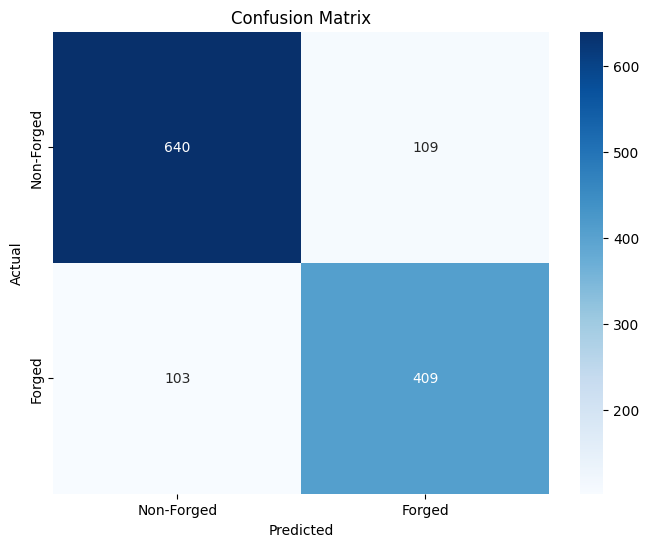

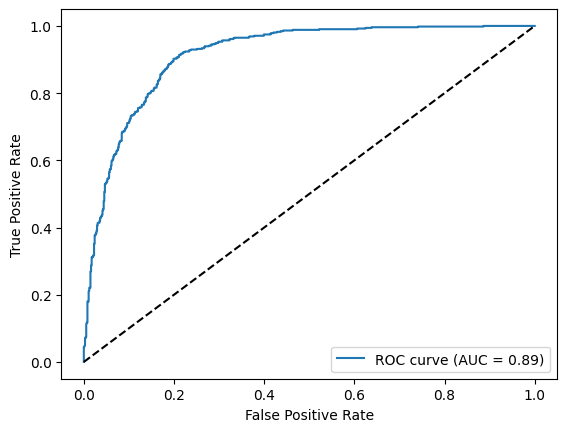

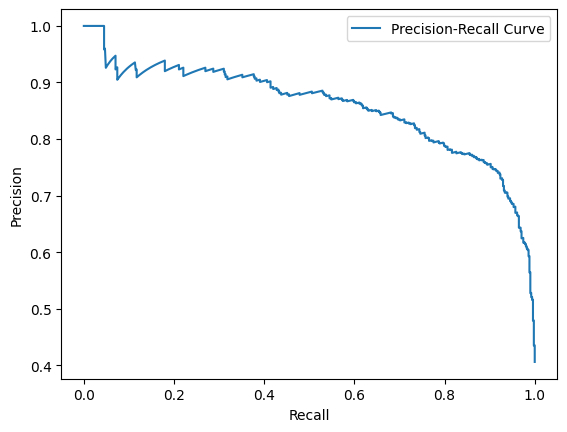

In [39]:
evaluate_model(model, X_test, y_test)

dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


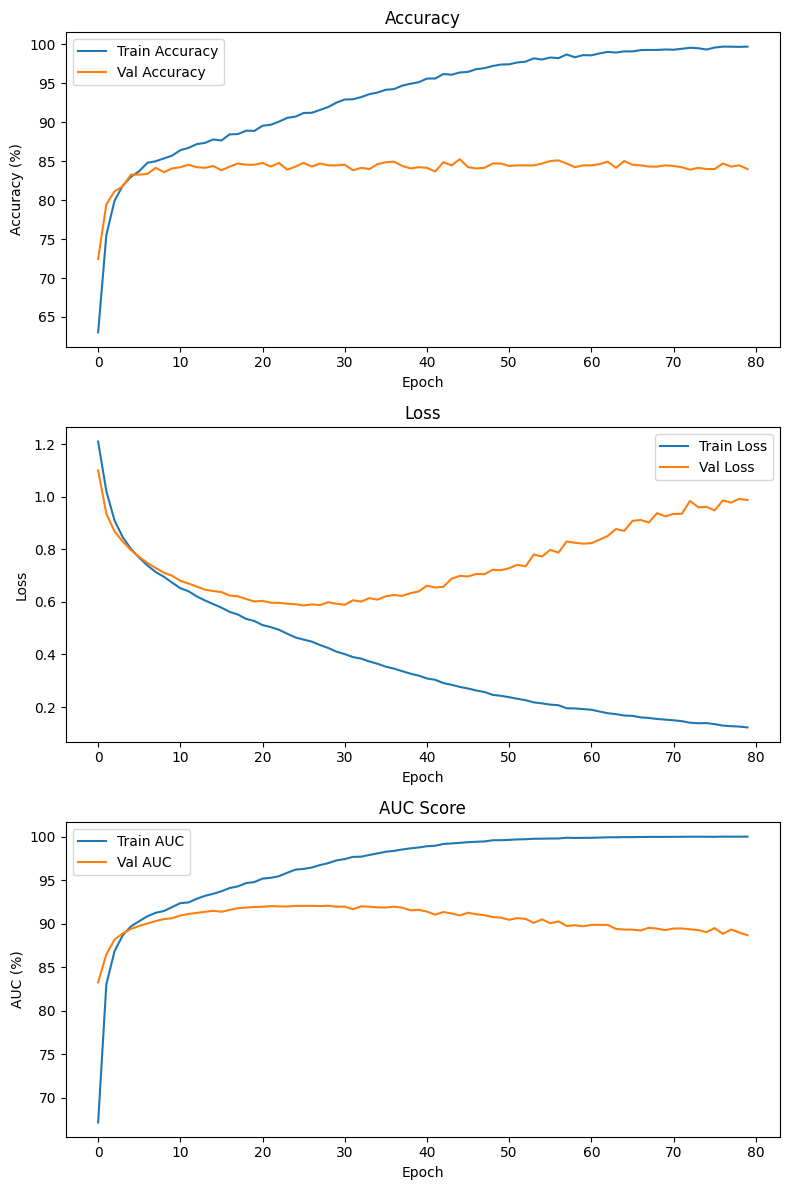

In [40]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history["accuracy"]) * 100, label="Train Accuracy")
    ax[0].plot(np.array(history.history["val_accuracy"]) * 100, label="Val Accuracy")
    ax[0].set_title("Accuracy")
    ax[0].set_ylabel("Accuracy (%)")
    ax[0].set_xlabel("Epoch")
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history["loss"]), label="Train Loss")
    ax[1].plot(np.array(history.history["val_loss"]), label="Val Loss")
    ax[1].set_title("Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    ax[2].plot(np.array(history.history["AUC"]) * 100, label="Train AUC")
    ax[2].plot(np.array(history.history["val_AUC"]) * 100, label="Val AUC")
    ax[2].set_title("AUC Score")
    ax[2].set_ylabel("AUC (%)")
    ax[2].set_xlabel("Epoch")
    # ax[2].set_ylim(80, 110)
    ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# Step 6: Plot training curves
plot_training_curves(history)